## Import the required libraries


In [1]:
# Auxiliary imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from collections import Counter

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Read the data from the .csv file and transfer it to a Pandas DataFrame

In [2]:
# Load dataset from csv file
column_names = ['mntcm', 'mxtwm', 'rfseas', 'tann', 'latitude', 'longitude', 'y']
data = pd.read_csv('dataset_bees.csv', names=column_names)

# Count the number of samples for each class
print(Counter(data['y']))

Counter({0.0: 9310, 1.0: 128})


#### Check the distribuition of the data in a pie chart

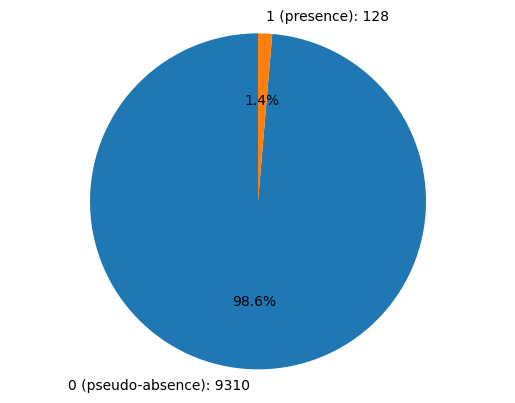

In [3]:
# Plot the number of samples for each class in a pie chart
sizes = [data['y'].value_counts()[0], data['y'].value_counts()[1]]
labels = f'0 (pseudo-absence): {sizes[0]}', f'1 (presence): {sizes[1]}'
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.show()

As seen in the pie chart, the dataset is unbalanced, with 98.6% of the samples belonging to the class 0 and 1.4% belonging to the class 1.

## Check the ploted data based on latitude and longitude before balancing

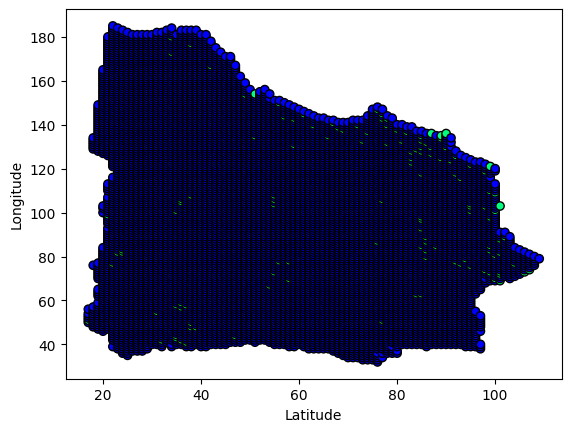

In [4]:
# Plot the samples in a scatter chart based on their latitude and longitude values
plt.figure()
legends = ['1 (presence)', '0 (pseudo-absence)']
plt.scatter(data['latitude'], data['longitude'], c=data['y'], cmap='winter' , edgecolors='k')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

As seen in the scatter chart above, the data is not well distributed, with most of the samples belonging to the class 0, drowning the class 1 samples.

## Balance the data by removing all outliers

This works by using a custom-made algorithm based on the euclidian distance. Since the imbalanced data comes from pseudo-absences (label 0) that are between the presences (label 1) it is only natural to remove all the pseudo-absences that are close to the presences by a determined threshold. The optimal threshold in evaluation is **23** units of distance, but, for data representation and reality, the optimal threshold is **10**, the latter being the final value chosen even if it doesn't have results as good.

This method proved to be super efficient giving excelent results in the evaluation phase.

In [5]:
# Define threshold
threshold = 10.0

# Divide the data into positives and negatives
data_positives = data[data['y'] == 1]
data_negatives = data[data['y'] == 0]
    
# Cycle through all the positives
for index, row in data_positives.iterrows():
    # Get the latitude and longitude of the positive
    lat = row['latitude']
    lon = row['longitude']
    # Get the euclidian distance between the positive and all the negatives
    distance = np.sqrt((data_negatives['latitude'] - lat)**2 + (data_negatives['longitude'] - lon)**2)
    
    # Remove all the negatives that are too close to the positive
    data_negatives = data_negatives[distance > threshold]

# Return the new data
data = pd.concat([data_positives, data_negatives])

## Check the ploted data after balancing

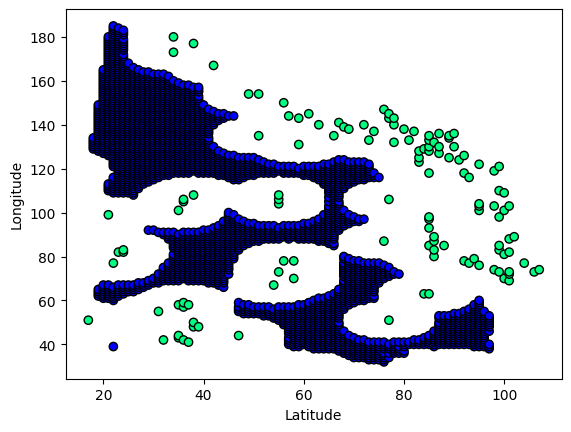

In [6]:
# Plot the samples in a scatter chart based on their latitude and longitude values
plt.figure()
legends = ['1 (presence)', '0 (pseudo-absence)']
plt.scatter(data['latitude'], data['longitude'], c=data['y'], cmap='winter' , edgecolors='k')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

#### Check the distribuition of the data in a pie chart after balancing

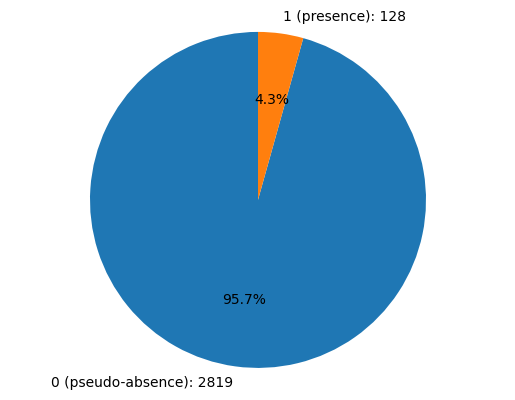

In [7]:
# Plot the number of samples for each class in a pie chart
sizes = [data['y'].value_counts()[0], data['y'].value_counts()[1]]
labels = f'0 (pseudo-absence): {sizes[0]}', f'1 (presence): {sizes[1]}'
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.show()

As observed in the pie chart, the dataset is now more balanced, making it a lot more efficient for the model training.

## Deal with the missing values in the dataset (NaN values)

There are many algorithms developed to deal with missing values. Some aim to remove missing values others to fill these. In this context, and since the missing values belong to the presences, it is crucial not to delete them. Therefore every NaN value will be replaced by the average of all values ​​belonging to the same class (in this case class 1).

In [8]:
# Deal with missing values in dataset (replace with mean value of rows with the same y (label) value)) 
data = data.fillna(data.groupby('y').transform('mean'))

## Split the data into features and labels and then split it into training and testing data 

In [9]:
# Split dataset into features and labels
X = data[['mntcm', 'mxtwm', 'rfseas', 'tann']]
y = data['y']

# Split the dataset randomly into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Standardize the feature values to be between 0 and 1

This way we get a better performance since the descrepancy between values is smaller.

In [10]:
# Standardize features values to be between 0 and 1 (for better performance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Create a list of the pretended classifiers

This way code is not only cleaner and more optimized, but also more readable.

In [11]:
# Classifiers names and instances
classifier_names = ['KNN', 'Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression', 'Multilayer Perceptron']

classifiers = [ 
                KNeighborsClassifier(n_neighbors=3),
                DecisionTreeClassifier(),
                RandomForestClassifier(n_estimators=100),
                SVC(),
                LogisticRegression(),
                MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
            ]

## Train each classifier

Because all the classifiers are in a list it's easy to train them all

In [12]:
# Train each classifier
for classifier in classifiers:
    classifier.fit(X_train, y_train)

## Evaluate each classifier using **cross validation**

StratifiedKFold evaluation with 10 folds and shuffle.

In [13]:
# Evaluate each classifier using cross validation
skf = StratifiedKFold(n_splits=10, shuffle=True)

# Store the average score of 10 folds for each classifier
crossVal_score = []

print('Cross Validation Score:')
for classifier, name in zip(classifiers, classifier_names):
    scores = cross_val_score(classifier, X, y, cv=skf) # crossVal_score returns the f1 score for each fold of the cross validation (10 folds) 
    crossVal_score.append(scores.mean())
    print(name + ' : ' + str(scores.mean())) # Print the mean of the f1 scores

Cross Validation Score:
KNN : 0.9786198547215497
Decision Tree : 0.9759068373111957
Random Forest : 0.9806606710480803
SVM : 0.956567508359276
Logistic Regression : 0.9579257465698143
Multilayer Perceptron : 0.9609858180560359


## Plot the cross validation in a bar chart

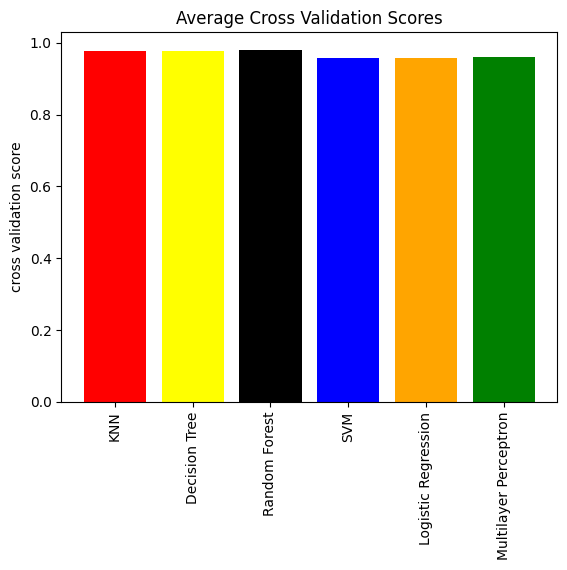

In [14]:
plt.figure()
plt.title("Average Cross Validation Scores")
plt.xticks(rotation='vertical')
plt.ylabel('cross validation score')
c = ['red', 'yellow', 'black', 'blue', 'orange', 'green']
plt.bar(classifier_names, crossVal_score, color=c, align="center")
plt.show()

## Plot the **ROC curve** and **AUC**

Instead of ploting the ROC curve and AUC with the fold values i found it better to simply use the roc_curve() function provided by scikit learn.

**fpr**: False positive rates;

**tpr**: True positive rates.

Since all classifiers are in a list, dictionaries of fpr, tpr and auc were created to make it easy to access the values of each classifier.

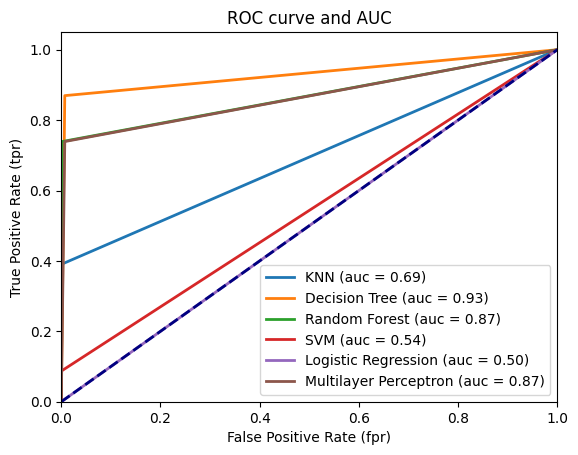

In [15]:
# Create dictionaries to store the values of each classifier
fpr = dict()
tpr = dict()
roc_auc = dict()
auc_scores = []

for classifier, name in zip(classifiers, classifier_names):
    y_pred = classifier.predict(X_test)
    fpr[name], tpr[name], _ = roc_curve(y_test, y_pred) 
    roc_auc[name] = auc(fpr[name], tpr[name])
    auc_scores.append(roc_auc[name])

# Plot all ROC curves
plt.figure()
lw = 2
for name in classifier_names:
    plt.plot(fpr[name], tpr[name], lw=lw, label=name + ' (auc = %0.2f)' % roc_auc[name])
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.title('ROC curve and AUC')
plt.legend(loc="lower right")
plt.show()

## Evaluate each classifier using **F1 Score**

According to multiple sources, the F1 score is one of the best metrics to determine the best classifier out of the bunch.

In [16]:
bestClassifier = classifiers[0]
bestClassifierName = classifier_names[0]
bestScore = 0

# List of f1 scores
f1_scores = []

print('F1 Scores:')
for classifier, name in zip(classifiers, classifier_names):
    y_pred = classifier.predict(X_test)
    score = classifier.score(X_test, y_test)
    print(name + ' : ' + str(score))
    f1_scores.append(score)

F1 Scores:
KNN : 0.9745762711864406
Decision Tree : 0.988135593220339
Random Forest : 0.988135593220339
SVM : 0.964406779661017
Logistic Regression : 0.9610169491525423
Multilayer Perceptron : 0.9830508474576272


## Plot the F1 scores for each classifier in a bar chart

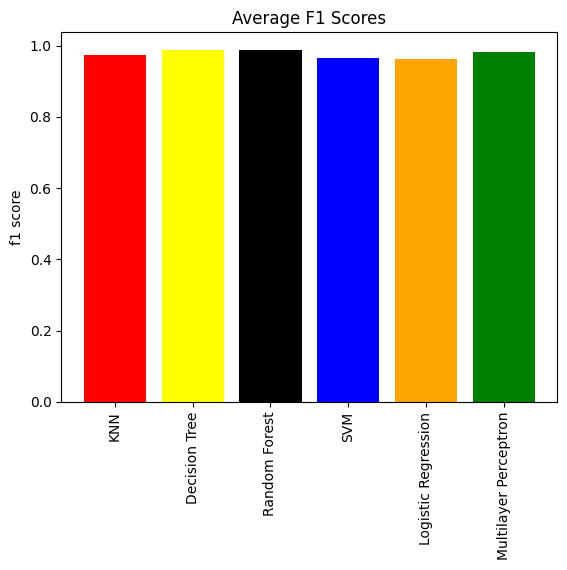

In [17]:
plt.figure()
plt.title("Average F1 Scores")
plt.xticks(rotation='vertical')
plt.ylabel('f1 score')
plt.bar(classifier_names, f1_scores, color=c, align="center")
plt.show()

## Plot the average score for each classifier using the three metrics (F1, AUC and Cross Validation) in a bar chart

Average Scores:
KNN: 0.8826554885352887
Decision Tree: 0.9650992341221721
Random Forest: 0.9458265491481854
SVM: 0.8214841829632861
Logistic Regression: 0.8063142319074522
Multilayer Perceptron: 0.936691515348099


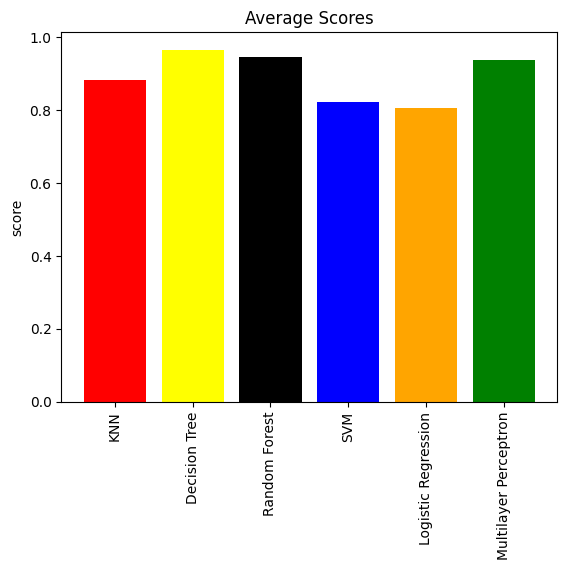

In [18]:
# Get the average list between the 3 lists
avg_scores = []
print('Average Scores:')
for i in range(len(f1_scores)):
    avg = (f1_scores[i] + crossVal_score[i] + auc_scores[i]) / 3
    print(classifier_names[i] + ': ' + str(avg))
    avg_scores.append(avg)
    
plt.figure()
plt.title("Average Scores")
plt.xticks(rotation='vertical')
plt.ylabel('score')
plt.bar(classifier_names, avg_scores, color=c, align="center")
plt.show()

## Get the best classifier based on the average scores of the three metrics (F1, AUC and Cross Validation)

In [19]:
best_classifier = classifiers[max(range(len(avg_scores)), key=avg_scores.__getitem__)]

print('The best classifier is: ' + classifier_names[max(range(len(avg_scores)), key=avg_scores.__getitem__)] + ' with score: ' + str(avg_scores[max(range(len(avg_scores)), key=avg_scores.__getitem__)]))

The best classifier is: Decision Tree with score: 0.9650992341221721


## Predict the test dataset using the best classifier

In [20]:
# Predict using the best classifier
y_pred = best_classifier.predict(X_test)

## Print the classification report of the best classification model

Scikit learn offers a method that prints a detailed report of a classification model.

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       567
         1.0       0.83      0.87      0.85        23

    accuracy                           0.99       590
   macro avg       0.91      0.93      0.92       590
weighted avg       0.99      0.99      0.99       590

